In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", 
    message="ModflowDis.sr is deprecated. use Modflow.sr")
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

## Model background
Here is an example based on the model of Freyberg, 1988.  The synthetic model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg, 1988; the last stress period use 25% less recharge and 25% more pumping.

The inverse problem has 761 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yield, calibration and forecast well flux for each of the six wells, and river bed conductance for each 40 cells with river-type boundary conditions.  The inverse problem has 12 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during both stress periods (observations named ```sw_gw_0``` and ``sw_gw_1``), and the water level in well cell 6 located in at row 28 column 5 at the end of the stress periods (observations named ```or28c05_0``` and ```or28c05_1```).  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

/Users/jwhite/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


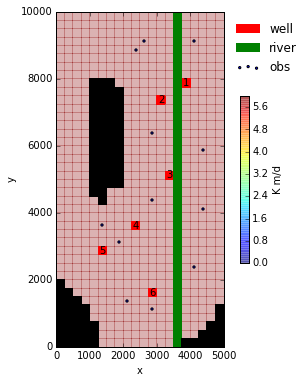

In [2]:
import flopy

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg.nam",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar="K m/d",alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),
                  delim_whitespace=True)
obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="obs")

#plot names on the pumping well locations
wel_data = ml.wel.stress_period_data[0]
wel_x = ml.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = ml.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.add_patch(rect((0,0),0,0,label="well",ec="none",fc="r"))
ax.add_patch(rect((0,0),0,0,label="river",ec="none",fc="g"))

ax.legend(bbox_to_anchor=(1.5,1.0),frameon=False)
plt.savefig("domain.pdf")

## Using `pyemu`

In [3]:
import pyemu

First create a linear_analysis object.  We will use `ErrVar`  derived type, which replicates the behavior of the `PREDVAR` suite of PEST as well as `ident_par` utility.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.  Remember you can pass a filename to the `verbose` argument to write log file.

Since most groundwater model history-matching analyses focus on adjusting hetergeneous hydraulic properties and not boundary condition elements, let's identify the well flux and recharge parameters as `omitted` in the error variance analysis.  We can conceptually think of this action as excluding these parameters from the history-matching process. Later we will explicitly calculate the penalty for not adjusting these parameters.

In [4]:
# get the list of forecast names from the pest++ argument
# in the pest control file
jco = os.path.join("freyberg","freyberg.jcb")
pst = pyemu.Pst(jco.replace("jcb","pst"))
omitted = [pname for pname in pst.par_names if \
           pname.startswith("wf") or pname.startswith("rch")]
forecasts = pst.pestpp_options["forecasts"].split(',')
la = pyemu.ErrVar(jco=jco,verbose="errvar_freyberg.log",
                  omitted_parameters=omitted)
print("observations, parameters found in jacobian:",la.jco.shape)

2016-07-02 10:06:22.201745 starting: opening errvar_freyberg.log for logging

2016-07-02 10:06:22.201842 starting: pre-loading base components

2016-07-02 10:06:22.201892 starting: loading jco: freyberg/freyberg.jcb

2016-07-02 10:06:22.213487 finished: loading jco: freyberg/freyberg.jcb took: 0:00:00.011595

2016-07-02 10:06:22.213543 starting: loading pst: freyberg/freyberg.pst

2016-07-02 10:06:22.257450 finished: loading pst: freyberg/freyberg.pst took: 0:00:00.043907

2016-07-02 10:06:22.257799 starting: loading parcov

2016-07-02 10:06:22.386395 finished: loading parcov took: 0:00:00.128596

2016-07-02 10:06:22.386784 starting: loading obscov

2016-07-02 10:06:22.478611 finished: loading obscov took: 0:00:00.091827

2016-07-02 10:06:22.478968 starting: loading forecasts

2016-07-02 10:06:22.489471 finished: loading forecasts took: 0:00:00.010503

2016-07-02 10:06:22.489533 finished: pre-loading base components took: 0:00:00.287691

2016-07-02 10:06:22.489553 starting: dropping pr

# Parameter identifiability
The `errvar` dervied type exposes a method to get a `pandas` dataframe of parameter identifiability information.  Recall that parameter identifiability is expressed as $d_i = \Sigma(\mathbf{V}_{1i})^2$, where $d_i$ is the parameter identifiability, which ranges from 0 (not identified by the data) to 1 (full identified by the data), and $\mathbf{V}_1$ are the right singular vectors corresonding to non-(numerically) zero singular values.  First let's look at the singular spectrum of $\mathbf{Q}^{\frac{1}{2}}\mathbf{J}$, where $\mathbf{Q}$ is the cofactor matrix and $\mathbf{J}$ is the jacobian:

In [5]:
s = la.qhalfx.s

2016-07-02 10:06:27.383056 starting: qhalfx

2016-07-02 10:06:27.383137 starting: qhalf

2016-07-02 10:06:27.384623 finished: qhalf took: 0:00:00.001486

2016-07-02 10:06:27.388783 finished: qhalfx took: 0:00:00.005727



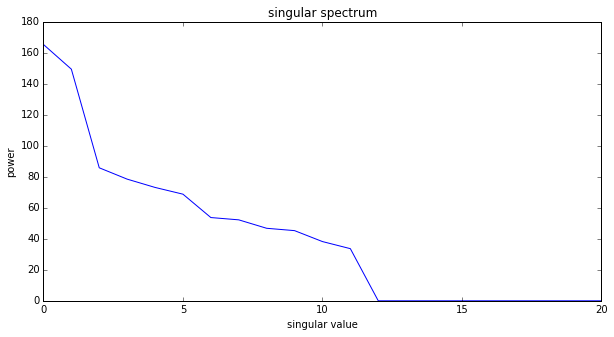

In [6]:
import pylab as plt
figure = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(s.x)
ax.set_title("singular spectrum")
ax.set_ylabel("power")
ax.set_xlabel("singular value")
ax.set_xlim(0,20)
plt.show()

We see that the singluar spectrum decays rapidly (not uncommon) and that we can really only support about 12 right singular vectors even though we have 700+ parameters in the inverse problem.  

Let's get the identifiability dataframe at 12 singular vectors:

In [7]:
# the method is passed the number of singular vectors to include in V_1
ident_df = la.get_identifiability_dataframe(12) 
ident_df.sort("ident",ascending=False).iloc[0:10]

2016-07-02 10:06:31.394825 starting: xtqx

2016-07-02 10:06:31.414330 finished: xtqx took: 0:00:00.019505



/Users/jwhite/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,right_sing_vec_6,right_sing_vec_7,right_sing_vec_8,right_sing_vec_9,right_sing_vec_10,right_sing_vec_11,right_sing_vec_12,ident
hkr30c15,3.166611e-07,8.174517e-06,1.148832e-04,3.791305e-06,4.162027e-04,2.920211e-05,0.000312,0.157966,1.535600e-04,0.143130,1.370435e-02,1.826393e-04,0.316021
hkr03c11,7.387509e-02,5.384317e-03,1.563092e-05,3.263432e-06,6.993039e-08,3.858914e-07,0.000271,0.000016,1.864741e-01,0.000087,4.355656e-05,7.427537e-04,0.266914
hkr34c09,5.380664e-04,1.044749e-02,7.571905e-02,1.288416e-01,2.271382e-02,1.716731e-02,0.000011,0.000034,1.173230e-05,0.000035,3.578772e-06,5.461963e-08,0.255523
hkr04c10,9.252799e-02,6.727379e-03,3.528366e-06,1.999631e-05,3.425899e-08,9.396064e-05,0.002246,0.000055,1.461497e-01,0.000042,7.540809e-06,2.142541e-05,0.247895
hkr22c12,6.136991e-04,8.347154e-03,2.617500e-02,8.158107e-02,1.095896e-03,7.830010e-02,0.025063,0.001078,3.596556e-05,0.000249,7.852045e-04,3.020249e-05,0.223355
hkr25c06,3.501033e-03,4.065834e-02,1.051907e-01,1.348417e-02,1.663367e-03,5.145010e-02,0.000154,0.000003,6.804377e-07,0.000003,5.383279e-07,2.857959e-07,0.216109
hkr35c12,1.166314e-04,1.810491e-03,7.863807e-03,5.822837e-04,1.944518e-01,6.399520e-05,0.000070,0.001227,1.274995e-06,0.000594,3.588170e-05,7.194233e-07,0.206818
hkr35c10,5.282756e-05,1.142425e-03,3.813508e-03,1.922685e-02,1.592644e-01,3.109583e-03,0.000002,0.000500,7.066986e-07,0.000237,1.074445e-05,1.681440e-07,0.187360
hkr04c16,3.617223e-07,3.615686e-08,3.591207e-09,1.975753e-08,2.155676e-09,1.393513e-07,0.000007,0.000047,7.701659e-05,0.000596,1.033084e-02,1.672193e-01,0.178277
hkr03c15,3.636806e-07,3.436517e-08,7.657491e-09,3.963778e-08,1.963746e-09,2.168016e-07,0.000009,0.000068,7.551133e-05,0.000747,1.121278e-02,1.657984e-01,0.177912


Plot the indentifiability:

/Users/jwhite/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


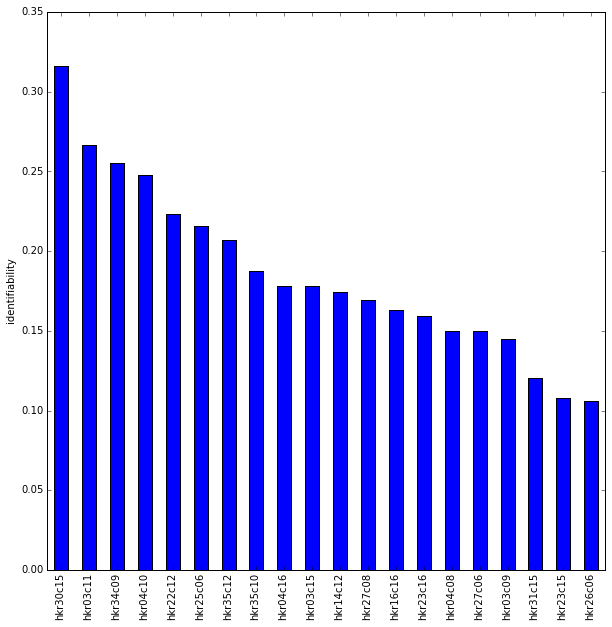

In [8]:
ax = ident_df.sort("ident",ascending=False).iloc[0:20].\
     loc[:,"ident"].plot(kind="bar",figsize=(10,10))
ax.set_ylabel("identifiability")

# Forecast error variance 

Now let's explore the error variance of the forecasts we are interested in.  We will use an extended version of the forecast error variance equation:   

$\sigma_{s - \hat{s}}^2 = \underbrace{\textbf{y}_i^T({\bf{I}} - {\textbf{R}})\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_i}({\textbf{I}} - {\textbf{R}})^T\textbf{y}_i}_{1} + \underbrace{{\textbf{y}}_i^T{\bf{G}}\boldsymbol{\Sigma}_{\mathbf{\epsilon}}{\textbf{G}}^T{\textbf{y}}_i}_{2} + \underbrace{{\bf{p}}\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_o}{\bf{p}}^T}_{3}$

Where term 1 is the null-space contribution, term 2 is the solution space contribution and term 3 is the model error term (the penalty for not adjusting uncertain parameters).  Remember the well flux and recharge parameters that we marked as omitted?  The consequences of that action can now be explicitly evaluated.  See Moore and Doherty (2005) and White and other (2014) for more explanation of these terms.  Note that if you don't have any `omitted_parameters`, the only terms 1 and 2 contribute to error variance

First we need to create a list (or numpy ndarray) of the singular values we want to test.  Since we have 12 data, we only need to test up to $13$ singular values because that is where the action is:

In [9]:
sing_vals = np.arange(13)

The `ErrVar` derived type exposes a method to get a multi-index pandas dataframe with each of the terms of the error variance equation:

In [10]:
errvar_df = la.get_errvar_dataframe(sing_vals)
errvar_df.iloc[0:10]

2016-07-02 10:06:35.636558 starting: calc first term parameter @0

2016-07-02 10:06:35.669838 finished: calc first term parameter @0 took: 0:00:00.033280

2016-07-02 10:06:35.669954 starting: calc second term prediction @0

2016-07-02 10:06:35.690332 finished: calc second term prediction @0 took: 0:00:00.020378

2016-07-02 10:06:35.691101 starting: calc third term prediction @0

2016-07-02 10:06:35.695865 finished: calc third term prediction @0 took: 0:00:00.004764

2016-07-02 10:06:35.695932 starting: calc first term parameter @1

2016-07-02 10:06:35.725526 finished: calc first term parameter @1 took: 0:00:00.029594

2016-07-02 10:06:35.725906 starting: calc second term prediction @1

2016-07-02 10:06:35.726336 starting: calc G @1

2016-07-02 10:06:35.741861 finished: calc G @1 took: 0:00:00.015525

2016-07-02 10:06:35.758648 finished: calc second term prediction @1 took: 0:00:00.032742

2016-07-02 10:06:35.759058 starting: calc third term prediction @1

2016-07-02 10:06:35.763465 fin

first                                         second            \
  or28c05_0 or28c05_1      sw_gw_0       sw_gw_1 or28c05_0 or28c05_1   
0  0.303632  0.744522  2346.665821  93125.784926  0.000000  0.000000   
1  0.286190  0.735479  2320.763341  93111.468642  0.000003  0.000001   
2  0.112759  0.644095  2091.267000  93072.383387  0.000034  0.000018   
3  0.112481  0.643973  1988.328320  93005.539544  0.000034  0.000018   
4  0.112188  0.643828  1956.305907  92895.692286  0.000034  0.000018   
5  0.111377  0.642628  1713.097707  92823.789675  0.000035  0.000019   
6  0.104556  0.635848  1712.675425  92823.463404  0.000040  0.000024   
7  0.104542  0.635847  1712.623036  92819.347027  0.000040  0.000024   
8  0.104540  0.635847  1712.436907  92814.867720  0.000040  0.000024   
9  0.104540  0.635847  1712.427939  92814.858862  0.000040  0.000024   

                          third                                        
    sw_gw_0   sw_gw_1 or28c05_0 or28c05_1       sw_gw_0       sw_gw_1  
0  0.000000  0.000000  0.097391  0.028892  77287.368771  18422.570689  
1  0.003789  0.002094  0.060875  0.024235  78685.159995  18317.519593  
2  0.044894  0.009095  0.001243  0.040499  83074.013715  18501.598821  
3  0.100812  0.045405  0.001409  0.040046  83991.198667  18580.773147  
4  0.121600  0.116718  0.001395  0.040083  83948.186043  18572.818586  
5  0.303456  0.170482  0.001749  0.038579  85506.951644  18668.036457  
6  0.303812  0.170757  0.002600  0.036227  85553.358127  18672.613994  
7  0.303885  0.176465  0.002523  0.036261  85582.579244  18643.796811  
8  0.304158  0.183033  0.002482  0.036289  85649.379181  18607.521865  
9  0.304174  0.183049  0.002481  0.036284  85652.894796  18607.904214

In [11]:
errvar_df[["first"]].to_latex("sw_gw_0.tex")

plot the error variance components for each forecast:

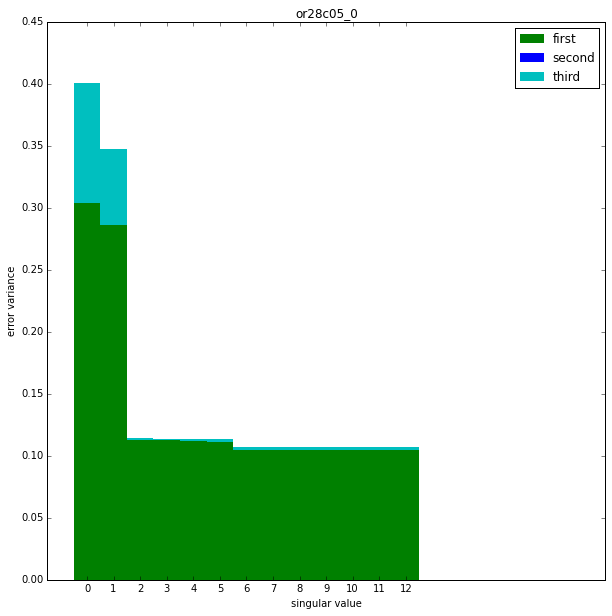

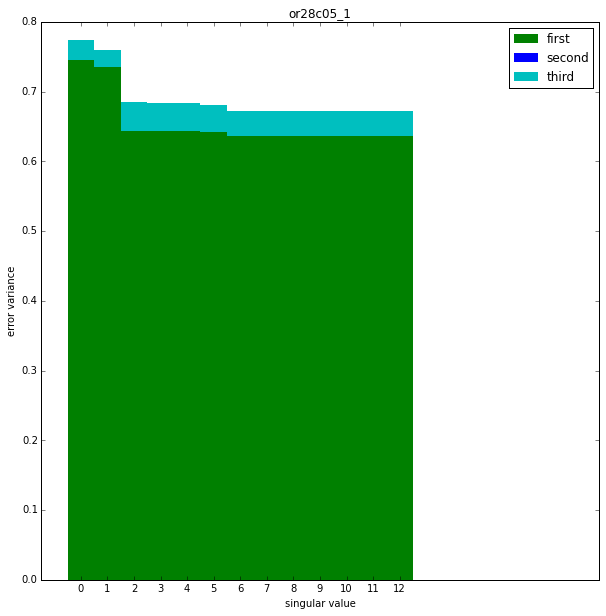

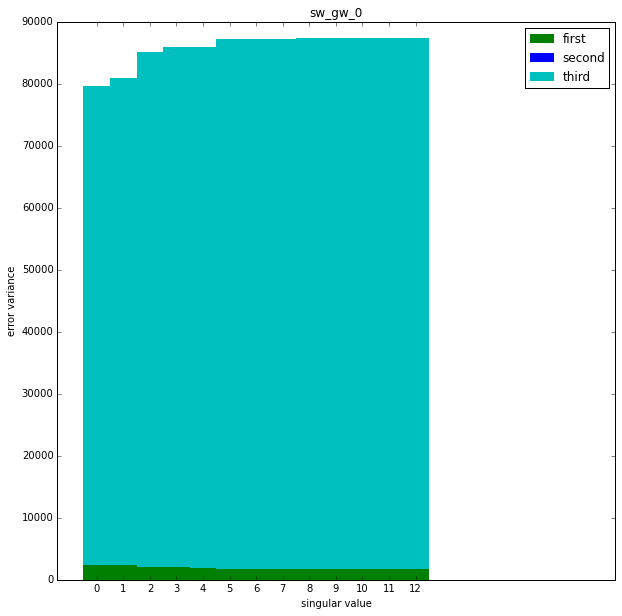

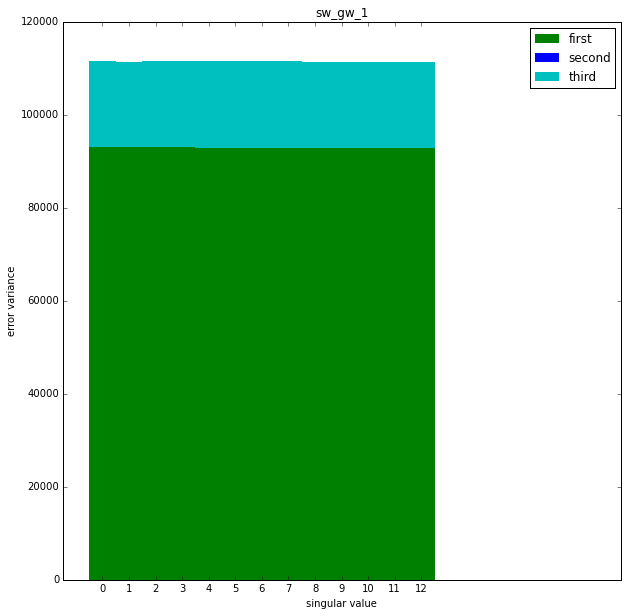

In [12]:
colors = {"first": 'g', "second": 'b', "third": 'c'}
max_idx = 19
idx = sing_vals[:max_idx]
for ipred, pred in enumerate(forecasts):
    pred = pred.lower()
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.set_title(pred)
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]
    third = errvar_df[("third", pred)][:max_idx]
    ax.bar(idx, first, width=1.0, edgecolor="none", 
           facecolor=colors["first"], label="first",bottom=0.0)
    ax.bar(idx, second, width=1.0, edgecolor="none", 
           facecolor=colors["second"], label="second", bottom=first)
    ax.bar(idx, third, width=1.0, edgecolor="none", 
           facecolor=colors["third"], label="third", 
           bottom=second+first)
    ax.set_xlim(-1,max_idx+1)
    ax.set_xticks(idx+0.5)
    ax.set_xticklabels(idx)
    #if ipred == 2:
    ax.set_xlabel("singular value")
    ax.set_ylabel("error variance")
    ax.legend(loc="upper right")
plt.show()

Here we see the trade off between getting a good fit to push down the null-space (1st) term and the penalty for overfitting (the rise of the solution space (2nd) term)).  The sum of the first two terms in the "appearent" error variance (e.g. the uncertainty that standard analyses would yield) without considering the contribution from the omitted parameters.  You can verify this by checking prior uncertainty from the Schur's complement notebook against the zero singular value result using only terms 1 and 2. Note that the top of the green bar is the limit of traditional uncertainty/error variance analysis: accounting for parameter and observation

We also see the added penalty for not adjusting the well flux and recharge parameters.  For the water level at the end of the calibration period forecast (``or28c05_0``), the fact the we have left parameters out doesn't matter - the parameter compensation associated with fixing uncertain model inputs can be "calibrated out" beyond 2 singular values.  For the water level forecast during forecast period (``or28c05_1``), the penalty for fixed parameters persists -it s nearly constant over the range of singular values.  

For ``sw_gw_0``, the situation is much worse: not only are we greatly underestimating uncertainty by omitting parameters, worse, calibration increases the uncertainty for this forecast because the adjustable parametres are compensating for the omitted, uncertaint parameters in ways that are damanaging to the forecast. 

For the forecast period sw-gw exchange (``sw_gw_1``), calibration doesn't help or hurt - this forecast depend entirely on null space parameter components.  But treating the recharge and well pumpage as "fixed" (omitted) results in greatly underestimated uncertainty.     

Let's check the ```errvar``` results against the results from ```schur```. This is simple with ```pyemu```, we simply  cast the ```errvar``` type to a ```schur``` type:

In [13]:
schur = la.get(astype=pyemu.Schur)
schur_prior = schur.prior_forecast
schur_post = schur.posterior_forecast
print("{0:10s} {1:>12s} {2:>12s} {3:>12s} {4:>12s}"
      .format("forecast","errvar prior","errvar min",
              "schur prior", "schur post"))
for ipred, pred in enumerate(forecasts):
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]  
    min_ev = np.min(first + second)
    prior_ev = first[0] + second[0]
    prior_sh = schur_prior[pred]
    post_sh = schur_post[pred]
    print("{0:12s} {1:12.6f} {2:12.6f} {3:12.6} {4:12.6f}"
          .format(pred,prior_ev,min_ev,prior_sh,post_sh))

2016-07-02 10:06:42.694343 WARNING: LinearAnalysis.get(): astype is not None, but par_names and obs_names are None so
  ->Omitted attributes will not be propagated to new instance

forecast   errvar prior   errvar min  schur prior   schur post
or28c05_0        0.303632     0.104580     0.303632     0.104580
or28c05_1        0.744522     0.635871     0.744522     0.635871
sw_gw_0       2346.665821  1712.432492      2346.67  1712.432302
sw_gw_1      93125.784926 92814.664135      93125.8 92814.664006


We see that the prior from ```schur``` class matches the two-term ```errvar``` result at zero singular values.  We also see, as expected, the posterior from ```schur``` is slightly lower than the two-term ```errvar``` result.  This shows us that the "appearent" uncertainty in these predictions, as found through application of Bayes equation, is being under estimated because if the ill effects of the omitted parameters.